In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from utils import *
from equations import *

In [2]:
epochADAM = 400000
epochLBFGS = 0
N_u=4000
N_H=4000
N_f=9000
N_C=None
seed=1234
log_frequency=10000
history_frequency=10
NLayers=6
NNeurons=40
noiseLevel=[]
weights = [5,3,5,8,14]

In [3]:
hp = {}
# Data size on the solution u
hp["N_u"] = N_u
hp["N_s"] = N_u
hp["N_H"] = N_H
hp["N_C"] = N_C
# Collocation points size, where we’ll check for f = 0
hp["N_f"] = N_f
# DeepNN topology (2-sized input [x,y], NLayers hidden layer of NNeurons-width, 1-sized output [u,v]
hp["layers"] = [2]+[NNeurons]*NLayers+[2]
# DeepNN topology (1-sized input [x,y], NLayers hidden layer of NNeurons-width, 2-sized output [h, H]
hp["h_layers"] = [2]+[NNeurons]*NLayers+[2]
# DeepNN topology (1-sized input [x,y], NLayers hidden layer of NNeurons-width, 1-sized output [C]
hp["C_layers"] = [2]+[NNeurons]*NLayers+[1]
# DeepNN topology (1-sized input [x], NLayers hidden layer of NNeurons-width, 4-sized input [u,v,C], 
#   1-sized output [taub]
hp["friction_layers"] = [4]+[NNeurons]*NLayers+[1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
hp["tf_epochs"] = epochADAM
hp["tf_lr"] = 0.001
hp["tf_b1"] = 0.99
hp["tf_eps"] = 1e-1
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
hp["nt_epochs"] = epochLBFGS
hp["log_frequency"] = log_frequency
# Record the history
hp["save_history"] = True
hp["history_frequency"] = history_frequency

# path for loading data and saving models
repoPath = "./"
appDataPath = os.path.join(repoPath, "matlab_SSA", "DATA")
# path = os.path.join(appDataPath, "Helheim_Big_PINN_obs_ITSLIVE0.mat")
path = os.path.join(appDataPath, "Helheim_Weertman_iT080_PINN_fastflow_CF_1500.mat")
# path = os.path.join(appDataPath, "Helheim_Weertman_iT080_PINN_fastflow_fl.mat")



# modelPath = './Models/SSA2D_3NN_test_NH2000_3NN_6x20_weights5_3_5_10_16_20231111_082315'
# modelPath = './Models/SSA2D_3NN_test_NH1000_3NN_6x20_weights5_3_5_10_16_20231111_025930'
# modelPath = './Models/SSA2D_3NN_test_NH500_3NN_6x20_weights5_3_5_10_16_20231110_213928'
# modelPath = './Models/SSA2D_3NN_test_NH250_3NN_6x20_weights5_3_5_10_16_20231110_161914'
# modelPath = './Models/SSA2D_3NN_knowningC_3NN_6x20_weights5_3_5_10_16_20231113_142344'
# modelPath = './Models/SSA2D_knowningC_3NN_6x20_weights5_3_5_10_16_20231113_210249'
# modelPath = './Models/SSA2D_3NN_fl_3NN_6x20_weights5_3_5_10_16_20231113_190344'
# modelPath = './Models/SSA2D_3NN_test_NH125_3NN_6x20_weights5_3_5_10_16_20231114_162319'
# modelPath = './Models/SSA2D_Rignot2012_3NN_6x20_weights5_3_5_10_16_20231115_081042'
modelPath = './Models/SSA2D_FlightTrackH250_3NN_6x20_weights5_3_5_8_14_20231127_152002'



reloadModel = True
weights = [5, 3, 5, 10, 16]
loss_weights = [10**(-w) for w in weights]


In [4]:
x, y, Exact_vx, Exact_vy, X_star, u_star, X_u_train, u_train, X_f, X_bc, u_bc, X_cf, n_cf, xub, xlb, uub, ulb, mu = prep_2D_data_all(path, N_f=hp["N_f"], N_u=hp["N_u"], N_s=hp["N_s"], N_H=hp["N_H"], N_C=hp["N_C"],FlightTrack=True) #}}}

Use 255 flight track data for the ice thickness training data


In [5]:
X_u_train['H'].shape

(797, 2)

In [6]:
logger = Logger(hp)
pinn = SSA_3NN(hp, logger, X_f,
            X_cf, n_cf,
            xub, xlb, uub, ulb,
            modelPath, reloadModel,
            mu=mu,
            loss_weights=loss_weights)

Hyperparameters:
{
  "N_u": 4000,
  "N_s": 4000,
  "N_H": 4000,
  "N_C": null,
  "N_f": 9000,
  "layers": [
    2,
    40,
    40,
    40,
    40,
    40,
    40,
    2
  ],
  "h_layers": [
    2,
    40,
    40,
    40,
    40,
    40,
    40,
    2
  ],
  "C_layers": [
    2,
    40,
    40,
    40,
    40,
    40,
    40,
    1
  ],
  "friction_layers": [
    4,
    40,
    40,
    40,
    40,
    40,
    40,
    1
  ],
  "tf_epochs": 400000,
  "tf_lr": 0.001,
  "tf_b1": 0.99,
  "tf_eps": 0.1,
  "nt_epochs": 0,
  "log_frequency": 10000,
  "save_history": true,
  "history_frequency": 10
}

TensorFlow version: 2.4.1
Eager execution: True
GPU-accerelated: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
pinn.model.layers[-1].weights

[<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([-5.34427584e-06, -1.52559958e-04])>,
 <tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([2.25062120e-04, 2.24363605e-05])>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>]

In [8]:
pinn.h_model.layers[-1].weights

[<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([-869.43658111,   10.        ])>,
 <tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([1557.59447316, 1697.85587112])>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>]

In [9]:
#     yts = 3600*24*365
# #     X, Y = np.meshgrid(np.linspace(xlb[0],xub[0],200), np.linspace(xlb[1],xub[1], 200))
#     X, Y = np.meshgrid(np.linspace(269316.12931758, 313798.46025307,400), np.linspace(-2586842.03392523, -2547998.07427969, 400))

#     # obs
#     ux = yts*griddata(X_star, u_star[:,0].flatten(), (X, Y), method='cubic')
#     uy = yts*griddata(X_star, u_star[:,1].flatten(), (X, Y), method='cubic')
#     h_obs = griddata(X_star, u_star[:,2].flatten(), (X, Y), method='cubic')
#     H_obs = griddata(X_star, u_star[:,3].flatten(), (X, Y), method='cubic')
#     C_obs = griddata(X_star, u_star[:,4].flatten(), (X, Y), method='cubic')
#     taub_comp = u_star[:,4:5]**2*((u_star[:,0:1]**2.0+u_star[:,1:2]**2.0)**(1.0/6.0))
#     taub_model = griddata(X_star, taub_comp[:,0], (X, Y), method='cubic')

    
#     # predicted solution
#     u_pred, v_pred, h, H, C_pred = pinn.predict(X_star)
#     u_nn = yts*griddata(X_star, u_pred[:,0].flatten(), (X, Y), method='cubic')
#     v_nn = yts*griddata(X_star, v_pred[:,0].flatten(), (X, Y), method='cubic')
#     C_nn = griddata(X_star, C_pred[:,0], (X, Y), method='cubic')
#     h_nn = griddata(X_star, h[:,0], (X, Y), method='cubic')
#     H_nn = griddata(X_star, H[:,0], (X, Y), method='cubic')

#     H_interp = griddata(X_u_train['H'], u_train['H'].flatten(), (X, Y), method='cubic')
#     C_interp = griddata(X_u_train['C'], u_train['C'].flatten(), (X, Y), method='cubic')
#     # residual
#     f1, f2 = pinn.f_model()
#     F1 = griddata(X_f, f1[:,0], (X, Y), method='cubic')
#     F2 = griddata(X_f, f2[:,0], (X, Y), method='cubic')

In [10]:
#     vranges={'vel obs': [0,8e3], 'vel': [0,8e3], 'vel-vel obs':[-1e3,1e3], 
#              'H':[0,1500], 'H obs':[0,1500],'H interp':[0,1500], 
#              'H-H obs':[-0.25e3,0.25e3],'H-H interp':[-0.25e3,0.25e3], 
#              'C':[0,8e3], 'C obs':[0,8e3],'C-C obs':[-2e3,2e3],
#              's-s obs':[-100,100], 's':[-500,2000], 's obs':[-500,2000]
#           }
#     ###########################
#     plotData = {}
#     plotData['vel obs'] = np.sqrt(ux**2+uy**2)
#     plotData['s obs'] = h_obs
#     plotData['C obs'] = C_obs
#     plotData['H obs'] = H_obs
#     ###########################
#     vel = np.sqrt(u_nn**2+v_nn**2)
#     plotData['vel'] = vel
#     plotData['s'] = h_nn
#     plotData['C'] = np.abs(C_nn)
#     plotData['H'] = np.abs(H_nn)
#     ###########################
#     plotData['vel-vel obs'] =  plotData['vel'] -  plotData['vel obs'] 
#     plotData['s-s obs'] = h_nn - h_obs
#     plotData['C-C obs'] = plotData['C'] - C_obs
#     plotData['H-H obs'] = plotData['H'] - H_obs
#     plotData['H interp'] = H_interp
#     plotData['H-H interp'] = (H_obs - H_interp)
#     plotData['C interp'] = C_interp
#     plotData['Training data'] = 0*H_obs

# #     flagthin = (vel<2000)
# #     plotData['H-H interp'][flagthin] = 0
# #     plotData['H-H obs'][flagthin] = 0
    
#     fig, axs = plt.subplots(4, 4 , figsize=(16,12))

#     for ax,name in zip(axs.ravel(), plotData.keys()):
#         vr = vranges.setdefault(name, [None, None])
#         im = ax.imshow(plotData[name], interpolation='nearest', cmap='rainbow',
#                 extent=[X.min(), X.max(), Y.min(), Y.max()],
#                 vmin=vr[0], vmax=vr[1],
#                 origin='lower', aspect='auto')
#         ax.set_title(name)
#         fig.colorbar(im, ax=ax, shrink=1)
#         if name =='Training data':
#             ax.scatter(X_u_train['H'][:,0:1],X_u_train['H'][:,1:2],1,'black')
#             ax.scatter(X_u_train['C'][:,0:1],X_u_train['C'][:,1:2],1,'red')
#             ax.set_xlim(X.min(), X.max())
#             ax.set_ylim(Y.min(), Y.max())

In [11]:
    yts = 3600*24*365
    X, Y = np.meshgrid(np.linspace(xlb[0],xub[0],200), np.linspace(xlb[1],xub[1], 200))

    # obs
    ux = yts*griddata(X_star, u_star[:,0].flatten(), (X, Y), method='cubic')
    uy = yts*griddata(X_star, u_star[:,1].flatten(), (X, Y), method='cubic')
    h_obs = griddata(X_star, u_star[:,2].flatten(), (X, Y), method='cubic')
    H_obs = griddata(X_star, u_star[:,3].flatten(), (X, Y), method='cubic')
    C_obs = griddata(X_star, u_star[:,4].flatten(), (X, Y), method='cubic')
    taub_comp = u_star[:,4:5]**2*((u_star[:,0:1]**2.0+u_star[:,1:2]**2.0)**(1.0/6.0))
    taub_model = griddata(X_star, taub_comp[:,0], (X, Y), method='cubic')

    
    # predicted solution
    u_pred, v_pred, h, H, C_pred = pinn.predict(X_star)
    u_nn = yts*griddata(X_star, u_pred[:,0].flatten(), (X, Y), method='cubic')
    v_nn = yts*griddata(X_star, v_pred[:,0].flatten(), (X, Y), method='cubic')
    C_nn = griddata(X_star, C_pred[:,0], (X, Y), method='cubic')
    h_nn = griddata(X_star, h[:,0], (X, Y), method='cubic')
    H_nn = griddata(X_star, H[:,0], (X, Y), method='cubic')

    H_interp = griddata(X_u_train['H'], u_train['H'].flatten(), (X, Y), method='cubic')
    C_interp = griddata(X_u_train['C'], u_train['C'].flatten(), (X, Y), method='cubic')
    # residual
    f1, f2 = pinn.f_model()
    F1 = griddata(X_f, f1[:,0], (X, Y), method='cubic')
    F2 = griddata(X_f, f2[:,0], (X, Y), method='cubic')

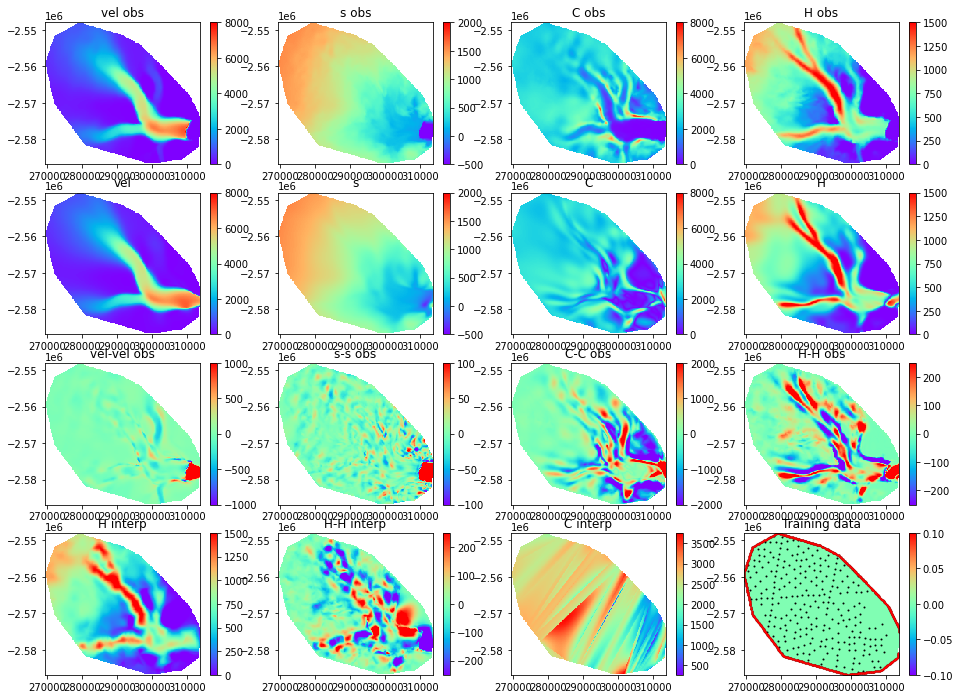

In [12]:
    vranges={'vel obs': [0,8e3], 'vel': [0,8e3], 'vel-vel obs':[-1e3,1e3], 
             'H':[0,1500], 'H obs':[0,1500],'H interp':[0,1500], 
             'H-H obs':[-0.25e3,0.25e3],'H-H interp':[-0.25e3,0.25e3], 
             'C':[0,8e3], 'C obs':[0,8e3],'C-C obs':[-2e3,2e3],
             's-s obs':[-100,100], 's':[-500,2000], 's obs':[-500,2000]
          }
    ###########################
    plotData = {}
    plotData['vel obs'] = np.sqrt(ux**2+uy**2)
    plotData['s obs'] = h_obs
    plotData['C obs'] = C_obs
    plotData['H obs'] = H_obs
    ###########################
    vel = np.sqrt(u_nn**2+v_nn**2)
    plotData['vel'] = vel
    plotData['s'] = h_nn
    plotData['C'] = np.abs(C_nn)
    plotData['H'] = np.abs(H_nn)
    ###########################
    plotData['vel-vel obs'] =  plotData['vel'] -  plotData['vel obs'] 
    plotData['s-s obs'] = h_nn - h_obs
    plotData['C-C obs'] = plotData['C'] - C_obs
    plotData['H-H obs'] = plotData['H'] - H_obs
    plotData['H interp'] = H_interp
    plotData['H-H interp'] = (H_obs - H_interp)
    plotData['C interp'] = C_interp
    plotData['Training data'] = 0*H_obs

#     flagthin = (vel<2000)
#     plotData['H-H interp'][flagthin] = 0
#     plotData['H-H obs'][flagthin] = 0
    
    fig, axs = plt.subplots(4, 4 , figsize=(16,12))

    for ax,name in zip(axs.ravel(), plotData.keys()):
        vr = vranges.setdefault(name, [None, None])
        im = ax.imshow(plotData[name], interpolation='nearest', cmap='rainbow',
                extent=[X.min(), X.max(), Y.min(), Y.max()],
                vmin=vr[0], vmax=vr[1],
                origin='lower', aspect='auto')
        ax.set_title(name)
        fig.colorbar(im, ax=ax, shrink=1)
        if name =='Training data':
            ax.scatter(X_u_train['H'][:,0:1],X_u_train['H'][:,1:2],1,'black')
            ax.scatter(X_u_train['C'][:,0:1],X_u_train['C'][:,1:2],1,'red')
            ax.set_xlim(X.min(), X.max())
            ax.set_ylim(Y.min(), Y.max())